In [1]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, WeightedRandomSampler
from tqdm import tqdm
from collections import Counter
import random
from PIL import Image

# ✅ Enable MKL-DNN optimization for CPU
torch.backends.mkldnn.enabled = True

print("Using CPU for training...")
# ✅ Choose Model: "mobilenet" (fastest) or "efficientnet" (higher accuracy)
MODEL_NAME = "mobilenet"  # Change to "efficientnet" if needed
SAVE_PATH = f"{MODEL_NAME}_best.pth"  # Automatically saves the best model

# ✅ Set dataset path
dataset_path = r"C:\Users\HP\Desktop\Data Set 2\Data Set 2"
# ✅ Check Dataset Balance (Count Real vs Fake)
real_dir = os.path.join(dataset_path, "train", "real")
fake_dir = os.path.join(dataset_path, "train", "fake")

real_count = len(os.listdir(real_dir)) if os.path.exists(real_dir) else 0
fake_count = len(os.listdir(fake_dir)) if os.path.exists(fake_dir) else 0

print(f"📊 Dataset Summary:")
print(f"✅ Real Images: {real_count}")
print(f"✅ Fake Images: {fake_count}")


Using CPU for training...
📊 Dataset Summary:
✅ Real Images: 19974
✅ Fake Images: 19974


In [2]:
from torchvision import transforms, datasets
import os

# ✅ Corrected Data Augmentation Pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),  
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),  
    transforms.RandomAffine(degrees=30, translate=(0.2, 0.2), scale=(0.8, 1.2)),  
    transforms.RandomPerspective(distortion_scale=0.5),  
    transforms.ToTensor(),  # 🔹 Must be after augmentations to avoid "Image has no attribute 'shape'"
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.5),  # 🔹 Should be last since it operates on tensors
])

# ✅ Load Dataset

train_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, "train"), transform=transform)
val_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, "val"), transform=transform)


In [3]:
# ✅ Fix Class Imbalance with Weighted Loss
class_counts = Counter([label for _, label in train_dataset.samples])
class_weights = torch.tensor([1.0 / class_counts[i] for i in range(len(class_counts))])
criterion = nn.CrossEntropyLoss(weight=class_weights)

# ✅ Use Weighted Sampling in DataLoader
sample_weights = [1.0 / class_counts[label] for _, label in train_dataset.samples]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)


In [4]:
# ✅ Define Model with Higher Dropout to Reduce Overfitting
def get_model(num_classes=2, model_name="mobilenet", pretrained=True):
    if model_name == "efficientnet":
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1 if pretrained else None)
        in_features = model.classifier[1].in_features
        model.classifier = nn.Sequential(
            nn.Dropout(0.8),  # 🔹 Increased dropout
            nn.Linear(in_features, num_classes)
        )
    elif model_name == "mobilenet":
        model = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V1 if pretrained else None)
        in_features = model.classifier[0].in_features
        model.classifier = nn.Sequential(
            nn.Linear(in_features, 1280),
            nn.Hardswish(),
            nn.Dropout(0.8),  # 🔹 Increased dropout
            nn.Linear(1280, num_classes)
        )
    else:
        raise ValueError("Invalid model name. Choose 'efficientnet' or 'mobilenet'.")
    return model

# 📌 Initialize Model
model = get_model(num_classes=2, model_name=MODEL_NAME)
# 🔥 Define Optimizer & Scheduler (Lower Learning Rate for More Stability)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001)  # 🔹 Lower learning rate
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)



In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report
import seaborn as sns

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10):
    best_val_loss = float('inf')
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    train_precisions, val_precisions = [], []
    train_recalls, val_recalls = [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        all_preds, all_labels = [], []

        print(f"\n🔄 Training Epoch {epoch+1}/{epochs}")
        for images, labels in tqdm(train_loader, desc="Training", leave=False):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Store predictions & labels for precision-recall computation
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        # Compute Precision & Recall for Training
        train_precision = precision_score(all_labels, all_preds, average="binary")
        train_recall = recall_score(all_labels, all_preds, average="binary")
        train_acc = 100 * correct / total

        # Validate Model
        val_loss, val_acc, val_precision, val_recall, val_conf_matrix = validate_model(model, val_loader, criterion)

        # Store metrics
        train_losses.append(running_loss / len(train_loader))
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        train_precisions.append(train_precision)
        val_precisions.append(val_precision)
        train_recalls.append(train_recall)
        val_recalls.append(val_recall)

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), SAVE_PATH)
            print(f"✅ Best model saved as {SAVE_PATH}!")

        scheduler.step(val_loss)

        print(f"📊 Epoch {epoch+1}/{epochs} | Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc:.2f}% | Train Precision: {train_precision:.2f} | Train Recall: {train_recall:.2f}")
        print(f"📊 Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | Val Precision: {val_precision:.2f} | Val Recall: {val_recall:.2f}")

    print("\n✅ Training complete!")

    # Print Final Confusion Matrix
    print("\n📌 Final Confusion Matrix on Validation Set:")
    plot_confusion_matrix(val_conf_matrix)

    # Plot Training & Validation Metrics
    plot_metrics(epochs, train_losses, val_losses, train_accuracies, val_accuracies, train_precisions, val_precisions, train_recalls, val_recalls)


# ✅ Validation Function with Precision, Recall, and Confusion Matrix
def validate_model(model, val_loader, criterion):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validating", leave=False):
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Store predictions & labels for evaluation
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute Precision, Recall & Confusion Matrix
    val_precision = precision_score(all_labels, all_preds, average="binary")
    val_recall = recall_score(all_labels, all_preds, average="binary")
    val_conf_matrix = confusion_matrix(all_labels, all_preds)

    val_loss = total_loss / len(val_loader)
    val_acc = 100 * correct / total
    return val_loss, val_acc, val_precision, val_recall, val_conf_matrix


# ✅ Function to Plot Confusion Matrix
def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()


# ✅ Function to Plot Training Metrics
def plot_metrics(epochs, train_losses, val_losses, train_accuracies, val_accuracies, train_precisions, val_precisions, train_recalls, val_recalls):
    plt.figure(figsize=(15, 5))

    # Loss Plot
    plt.subplot(1, 3, 1)
    plt.plot(range(1, epochs+1), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, epochs+1), val_losses, label='Val Loss', marker='s')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 3, 2)
    plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(range(1, epochs+1), val_accuracies, label='Val Accuracy', marker='s')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training & Validation Accuracy')
    plt.legend()

    # Precision & Recall Plot
    plt.subplot(1, 3, 3)
    plt.plot(range(1, epochs+1), train_precisions, label='Train Precision', marker='o')
    plt.plot(range(1, epochs+1), val_precisions, label='Val Precision', marker='s')
    plt.plot(range(1, epochs+1), train_recalls, label='Train Recall', marker='o')
    plt.plot(range(1, epochs+1), val_recalls, label='Val Recall', marker='s')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.title('Precision & Recall')
    plt.legend()

    plt.show()



🔄 Training Epoch 1/10


✅ Best model saved as mobilenet_best.pth!
📊 Epoch 1/10 | Train Loss: 0.6599 | Train Acc: 59.45% | Train Precision: 0.59 | Train Recall: 0.59
📊 Val Loss: 0.6460 | Val Acc: 61.80% | Val Precision: 0.69 | Val Recall: 0.43

🔄 Training Epoch 2/10


✅ Best model saved as mobilenet_best.pth!
📊 Epoch 2/10 | Train Loss: 0.5478 | Train Acc: 71.12% | Train Precision: 0.71 | Train Recall: 0.70
📊 Val Loss: 0.5755 | Val Acc: 69.78% | Val Precision: 0.73 | Val Recall: 0.64

🔄 Training Epoch 3/10


✅ Best model saved as mobilenet_best.pth!
📊 Epoch 3/10 | Train Loss: 0.4730 | Train Acc: 76.68% | Train Precision: 0.76 | Train Recall: 0.77
📊 Val Loss: 0.5385 | Val Acc: 72.75% | Val Precision: 0.78 | Val Recall: 0.63

🔄 Training Epoch 4/10


✅ Best model saved as mobilenet_best.pth!
📊 Epoch 4/10 | Train Loss: 0.4433 | Train Acc: 78.18% | Train Precision: 0.78 | Train Recall: 0.79
📊 Val Loss: 0.5013 | Val Acc: 75.44% | Val Precision: 0.78 | Val Recall: 0.71

🔄 Training Epoch 5/10


✅ Best model saved as mobilenet_best.pth!
📊 Epoch 5/10 | Train Loss: 0.4123 | Train Acc: 80.58% | Train Precision: 0.80 | Train Recall: 0.81
📊 Val Loss: 0.4802 | Val Acc: 76.50% | Val Precision: 0.80 | Val Recall: 0.71

🔄 Training Epoch 6/10


✅ Best model saved as mobilenet_best.pth!
📊 Epoch 6/10 | Train Loss: 0.3951 | Train Acc: 81.43% | Train Precision: 0.81 | Train Recall: 0.82
📊 Val Loss: 0.4546 | Val Acc: 78.14% | Val Precision: 0.80 | Val Recall: 0.75

🔄 Training Epoch 7/10


📊 Epoch 7/10 | Train Loss: 0.3803 | Train Acc: 82.16% | Train Precision: 0.82 | Train Recall: 0.83
📊 Val Loss: 0.4575 | Val Acc: 78.31% | Val Precision: 0.83 | Val Recall: 0.71

🔄 Training Epoch 8/10


✅ Best model saved as mobilenet_best.pth!
📊 Epoch 8/10 | Train Loss: 0.3716 | Train Acc: 82.78% | Train Precision: 0.82 | Train Recall: 0.83
📊 Val Loss: 0.4308 | Val Acc: 79.60% | Val Precision: 0.85 | Val Recall: 0.72

🔄 Training Epoch 9/10


✅ Best model saved as mobilenet_best.pth!
📊 Epoch 9/10 | Train Loss: 0.3576 | Train Acc: 83.37% | Train Precision: 0.83 | Train Recall: 0.84
📊 Val Loss: 0.4154 | Val Acc: 80.29% | Val Precision: 0.83 | Val Recall: 0.76

🔄 Training Epoch 10/10


✅ Best model saved as mobilenet_best.pth!
📊 Epoch 10/10 | Train Loss: 0.3471 | Train Acc: 84.12% | Train Precision: 0.84 | Train Recall: 0.85
📊 Val Loss: 0.4085 | Val Acc: 81.24% | Val Precision: 0.85 | Val Recall: 0.76

✅ Training complete!

📌 Final Confusion Matrix on Validation Set:


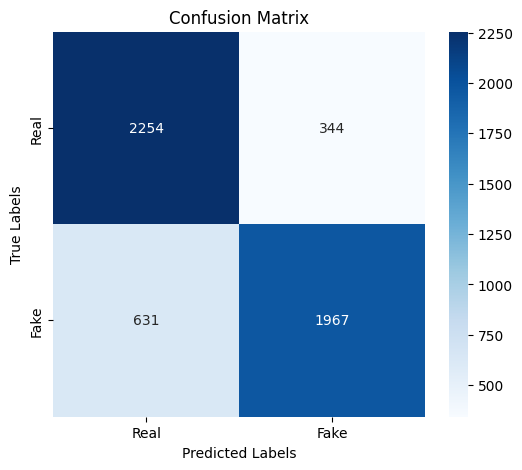

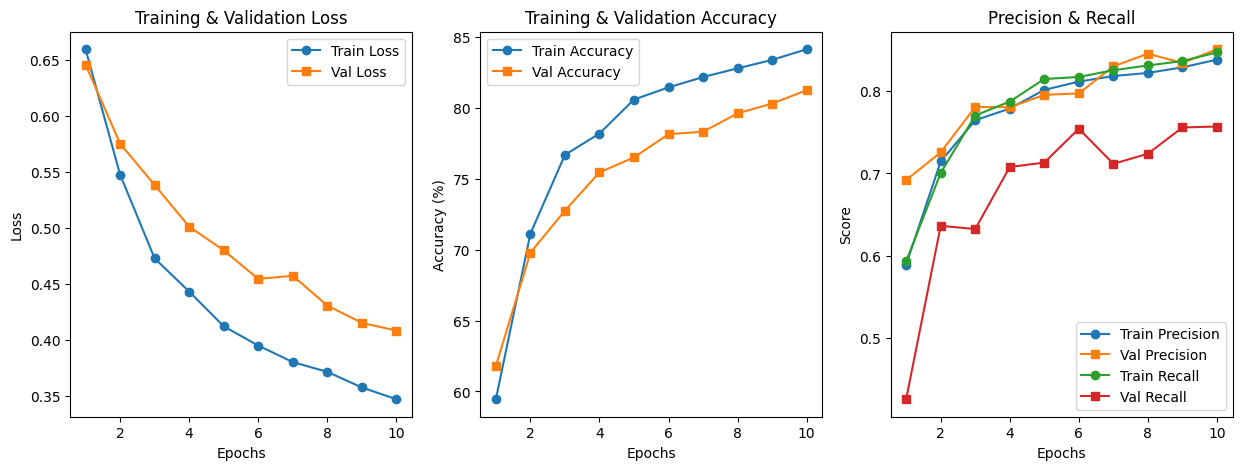

In [6]:
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10)


In [7]:
# ✅ Load the Best Saved Model
print(f"📥 Loading best model from {SAVE_PATH}...")

# ✅ Re-initialize the model with the same structure
model = get_model(num_classes=2, model_name=MODEL_NAME)

# ✅ Load the trained weights
model.load_state_dict(torch.load(SAVE_PATH))
model.eval()  # Set model to evaluation mode

print("✅ Model loaded successfully and ready for testing!")


📥 Loading best model from mobilenet_best.pth...
✅ Model loaded successfully and ready for testing!



🔍 Testing Model on a Custom Image:


📸 Enter image path for testing:  C:\Users\HP\Desktop\final_dataset\fake\0BJ8FHDRCL.jpg


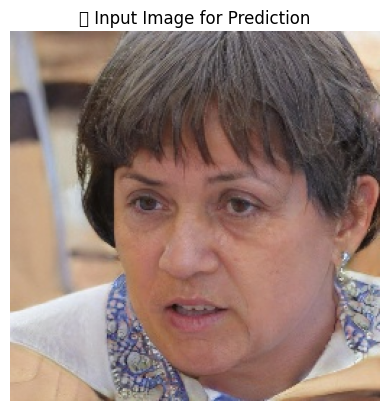

🎯 Predicted: Fake, Confidence: [0.9217402  0.07825988]


In [20]:

import os
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from PIL import Image

# ✅ Function to Predict an Image (User Input & Display It)
def predict_image(model):
    model.eval()
    
    # Ask user for image path
    image_path = input("📸 Enter image path for testing: ").strip()
    
    if not os.path.exists(image_path):
        print("❌ Error: Image file not found!")
        return

    # ✅ Load and Show the Image
    image = Image.open(image_path).convert("RGB")
    plt.imshow(image)
    plt.axis("off")
    plt.title("🔍 Input Image for Prediction")
    plt.show()

    # ✅ Apply Preprocessing
    image = transform(image).unsqueeze(0)  # Apply same preprocessing as training

    with torch.no_grad():
        output = model(image)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        _, predicted = torch.max(output, 1)

    class_names = ["Fake", "Real"]
    print(f"🎯 Predicted: {class_names[predicted.item()]}, Confidence: {probabilities.squeeze().numpy()}")

# ✅ Ask User for Image to Test
print("\n🔍 Testing Model on a Custom Image:")
predict_image(model)
